In [1]:
import numpy as np; np.random.seed(1218042)
import seaborn as sb; sb.set()
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Population Model of Competition between cancer and T cells

Let $f_{C}(t, u)$ and $f_{I}(t, u)$ model the local densities of cancer and T cells. Then their growths are determined by:

$$
\frac{\delta}{\delta t}f_{C}(t, u) = R_{C}(t, u)f_{C}(t, u)
$$
$$
\frac{\delta}{\delta t}f_{I}(t, v) = R_{I}(t, v)f_{I}(t, v)
$$

where $R_{C}$ and $R_{I}$ model the net proliferation rates of cancer cells and T cells, respectively:

$$
R_{C}(t, v) := (\kappa_{C} - \mu_{C}\rho_{C}(t)) - \int_{V} \eta_{\theta_{I}}(|u-v|)f_{I}(t, v)dv
$$
$$
R_{I}(t, v) := [\int_{U}\eta_{\theta_{E}}(|u-v|)f_{C}(t, u)du + \kappa_{P}c_{P}(t)] - \frac{\mu_{I}}{1+\mu_{M}c_{M}(t)}\rho_{I}(t)
$$

The implementation is as follows:

### $\kappa_{C, P}$ the natural growth rate of each cell type.

In [2]:
kappa_C = 1
kappa_P = 1

### $\mu_{C, I, M}$ the natural death rate of each cell type.

In [3]:
mu_C = 0.5
mu_I = 0.5
mu_M = 1

### $c_{P, M}$ the immune proliferation boosters.

In [4]:
c_P = lambda t: 0
c_M = lambda t: 0

### $f_{C}(t, u)$ and $f_{I}(t, v)$ local densities of cancer or T cells.

In [5]:
f_C = lambda u: np.exp(-np.square(u-0.5)/(0.001))
f_I = lambda v: (np.exp(v)-1)/v - 1

### $\rho_{C, I}$ the global densities of cells.

In [6]:
rho_C = lambda _f_C: sum(_f_C)
rho_I = lambda _f_I: sum(_f_I)

### $\theta_{E, I}$ the interaction selectivity parameters and $\eta_{\theta_{E}, \theta_{I}}$ the interaction rates.

In [7]:
theta_E = 1000 # leading to clonal expansion
theta_I = 1000 # leading to cancer death

# The interaction rates that lead to cancer cell death (<-> rider waiting time)
eta_theta_E = lambda u,v: np.exp(-theta_E*np.square(np.abs(u-v)))
# The interaction rates that lead to clonal expansion (<-> driver idle time)
eta_theta_I = lambda u,v: np.exp(-theta_I*np.square(np.abs(u-v)))

###  $R_{C, I}$ the proliferation rates.

In [8]:
R_C = lambda V,u,_f_C: (kappa_C - mu_C*rho_C(_f_C)) - sum([eta_theta_I(u, v) * v for v in V])
R_I = lambda U,v,_f_I: (sum([eta_theta_E(u, v) * u for u in U])  + kappa_C*c_P) - mu_I/(1 + mu_M*c_M * rho_I(_f_I))

## Modelling the growth

To recreate the model, $f_{C,I}$ will be an array of its values where each index reprents its value at time $t$.

At every time step, $f_{C, I}[t+1] = f_{C, I}[t] + \frac{\delta}{\delta t}f_{C, I}[t] = f_{C, I}[t] + R_{C, I} * f_{C, I}[t]$

We will compute this evolution for all possible starting values of $u$ and $v$.

In [9]:
def simulate_growth(N=25, t=121,
                    kappa_C=1, kappa_P=1,
                    mu_C=0.5, mu_I=0.5, mu_M=1,
                    c_P=lambda t: 0, c_M=lambda t: 0,
                    f_C=lambda u: np.exp(-np.square(u-0.5)/(0.001)),
                    f_I=lambda v: (np.exp(v)-1)/v - 1,
                    theta_E=1000, theta_I=1000):
    
    f_I = f_C
    
    eta_theta_E = lambda u,v: np.exp(-theta_E*np.square(np.abs(u-v)))
    eta_theta_I = lambda u,v: np.exp(-theta_I*np.square(np.abs(u-v)))
    
    R_C = lambda V,u,_f_C: (kappa_C - mu_C*rho_C(_f_C)) - sum([eta_theta_I(u, v) * v for v in V])
    R_I = lambda U,v,_f_I, t: (sum([eta_theta_E(u, v) * u for u in U])  + kappa_C*c_P(t)) - mu_I/(1 + mu_M*c_M(t) * rho_I(_f_I))
    
    # Initial values of cancer and T cells
    initial_values = np.linspace(0, 1, num=N)

    # Apply the growth equation for each time step
    for i in range(t):
        
        if i == 0:
            cancer = np.array([[f_C(u) for u in initial_values]])
            immune = np.array([[f_I(v) for v in initial_values]])
            continue
        
        # Get f_C/I[t]
        _f_C = cancer[-1]
        _f_I = immune[-1]

        # Compute f_C/I[t+1]
        delta_C = _f_C + _f_C * np.array([R_C(initial_values, u, _f_C) for u in _f_C])
        delta_I = _f_I + _f_I * np.array([R_I(initial_values, v, _f_I, i) for v in _f_I])

        # Filter out negative values
        delta_C = [max(d_C, 0) for d_C in delta_C]
        delta_I = [max(d_I, 0) for d_I in delta_I]
        
        cancer = np.concatenate((cancer, [delta_C]))
        immune = np.concatenate((immune, [delta_I]))
    
    return cancer, immune, initial_values

def plot_growth_surface(cancer, immune, initial_values, t=121):
    # Create a mesh-grid for printing
    initial_values, time = np.meshgrid(initial_values, np.arange(t))

    fig = plt.figure(figsize=(24, 8))

    #===============
    #  Cancer growth
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # Plot the surface
    ax.plot_surface(time, initial_values, cancer)

    # Set labels and title
    ax.set_xlabel('time', size=12)
    ax.set_ylabel('initial value of u', size=12)
    ax.set_zlabel('number of cancer cells (log)', size=12)
    plt.tight_layout()
    plt.title(f'Growth of cancer cells', size=15)

    #===============
    # Immune growth
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    # Plot the surface
    ax.plot_surface(time, initial_values, immune)

    # Set labels and title
    ax.set_xlabel('time', size=12)
    ax.set_ylabel('initial value of v', size=12)
    ax.set_zlabel('number of immune cells (log)', size=12)
    plt.tight_layout()
    plt.title(f'Growth of immune cells', size=15)

    # Show entire figure
    plt.show()
    
def plot_growth_cmap(cancer, immune, initial_values, t=121):

    fig = plt.figure(figsize=(12, 8))
    
    # Setup the tick marks (for time and initial values)
    xticks = [i if i in [0, 0.5, 1] else '' for i in initial_values]
    yticks = ['' if i % 20 else i for i in range(t)][::-1]

    #===============
    #  Cancer growth
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 3, 1)

    # Plot the heatmap
    ax = sb.heatmap(cancer[::-1], robust=True, xticklabels=xticks, yticklabels=yticks)

    # Set labels and title
    ax.set_xlabel('u', size=12)
    ax.set_ylabel('t', size=12)
    plt.tight_layout()
    plt.title(f'f_C(t, u)', size=15)

    #===============
    # Immune growth
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 3, 2)

    # Plot the heatmap
    ax = sb.heatmap(immune[::-1], robust=True, xticklabels=xticks, yticklabels=yticks)

    # Set labels and title
    ax.set_xlabel('v', size=12)
    ax.set_ylabel('t', size=12)
    plt.tight_layout()
    plt.title(f'f_I(t, v)', size=15)
    
    #===============
    # Densities
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 3, 3)

    # Plot the heatmap
    plt.plot(list(range(t)), cancer.sum(axis=1), color='black', label="Cancer cells")
    plt.plot(list(range(t)), immune.sum(axis=1), color='black', linestyle='--', label="Immune cells")

    # Set labels and title
    ax.set_xlabel('t', size=12)
    ax.set_xticks(list(range(0, t, 20)) if t==121 else list(range(t)))
    ax.set_ylabel('')
    plt.legend()
    plt.tight_layout()
    plt.title(f'ρ_C(t) and ρ_I(t)', size=15)

    # Show entire figure
    plt.show()

### Running the default simulation for 120 timesteps gives:

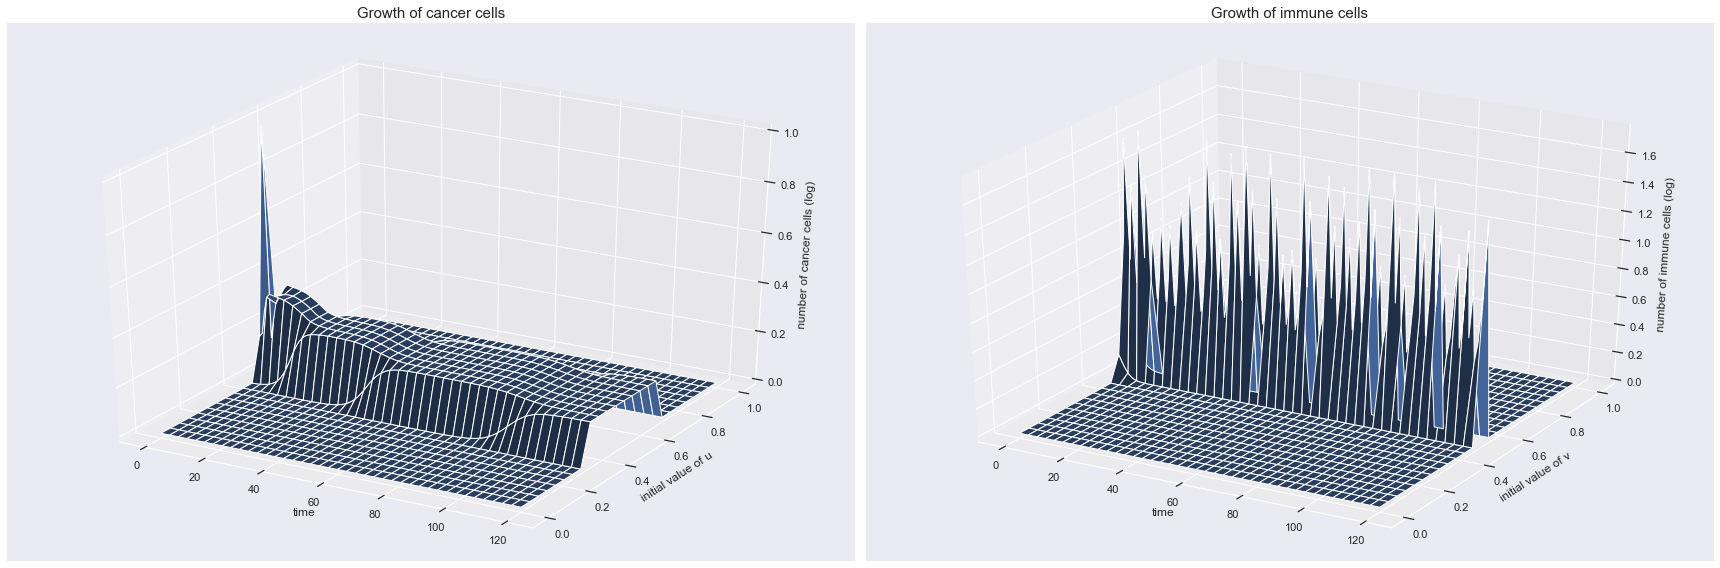

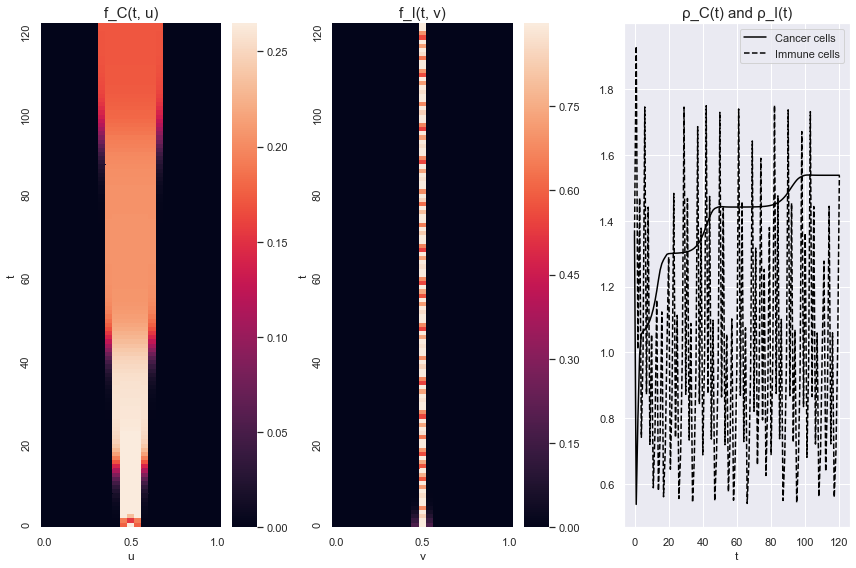

In [11]:
cancer, immune, initial_values = simulate_growth()
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)

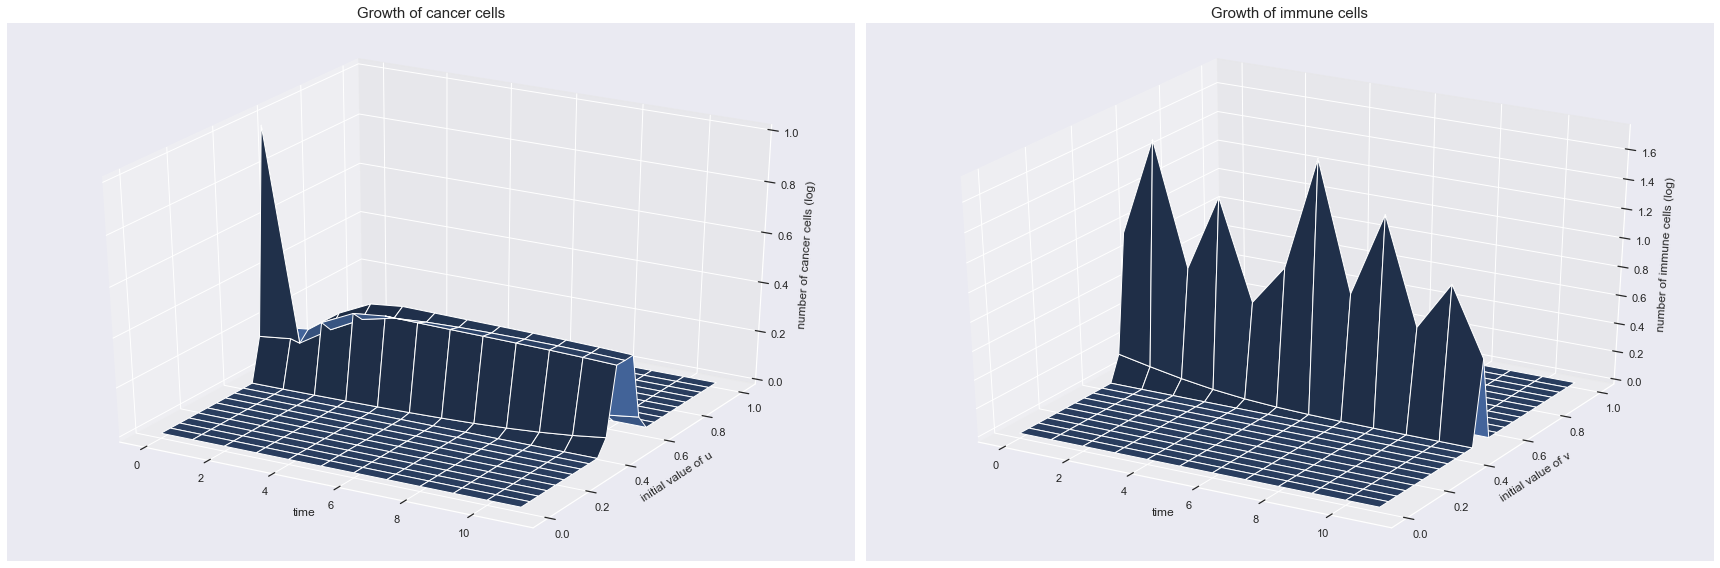

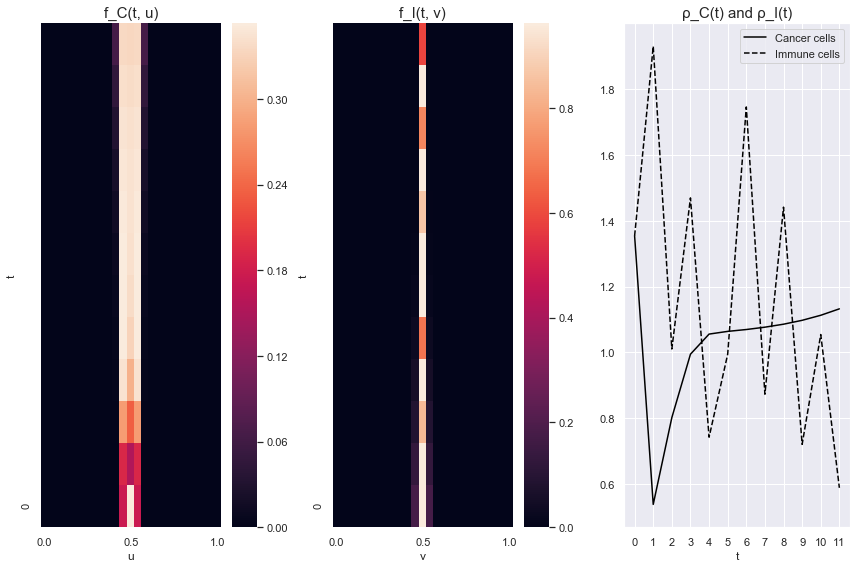

In [12]:
cancer, immune, initial_values = simulate_growth(t=12)
plot_growth_surface(cancer, immune, initial_values, t=12)
plot_growth_cmap(cancer, immune, initial_values, t=12)

### Now setting $c_P(t) = C*\operatorname{sgn}(\sin(\omega*t)) \quad c_M(t) = 0$

where the paper defines $C \in \{4, 6, 8\}$ and $\omega = \frac{10*\pi}{T}\ (T\approx20)$

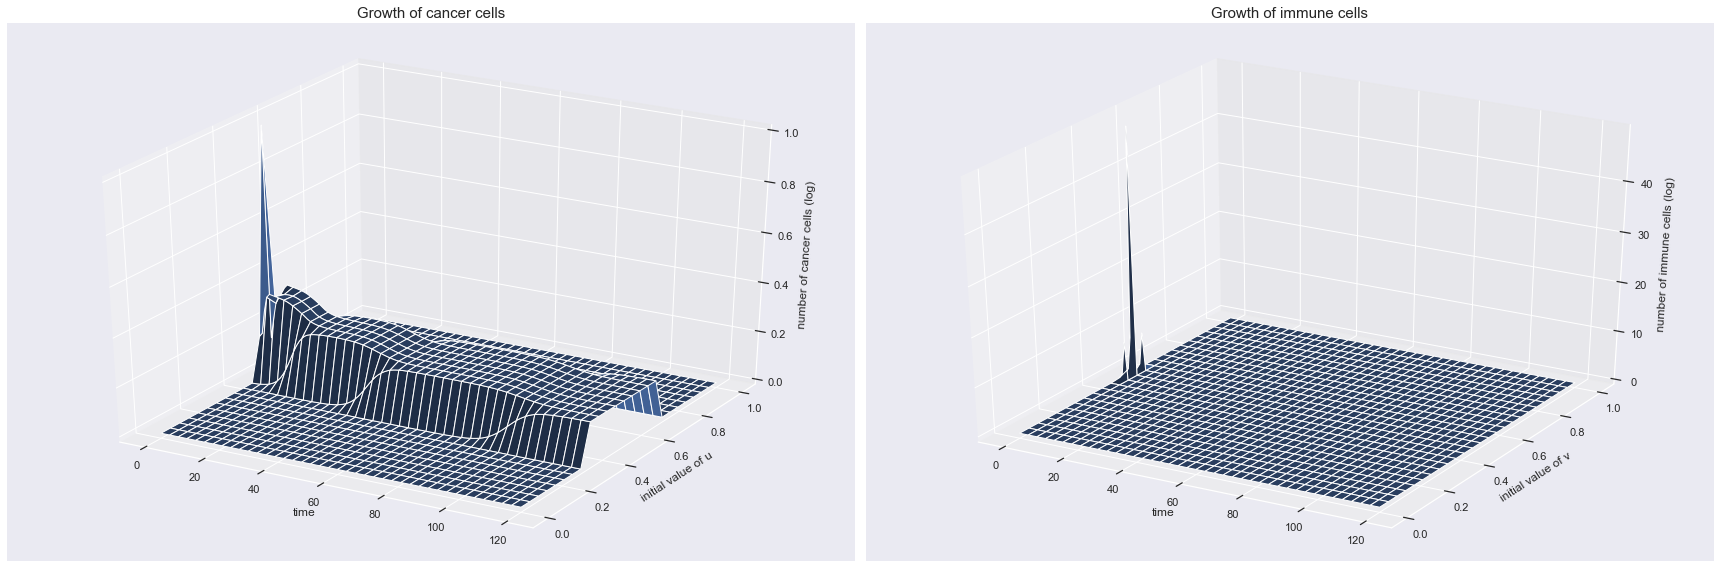

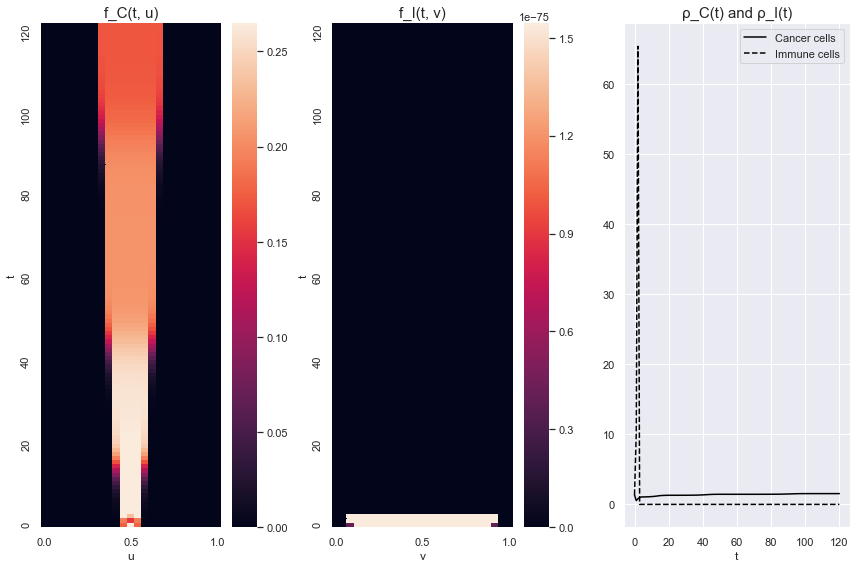

In [13]:
C = 6
omega = np.pi/2
cancer, immune, initial_values = simulate_growth(c_P=lambda t: C*np.sign(np.sin(omega*t)))
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)

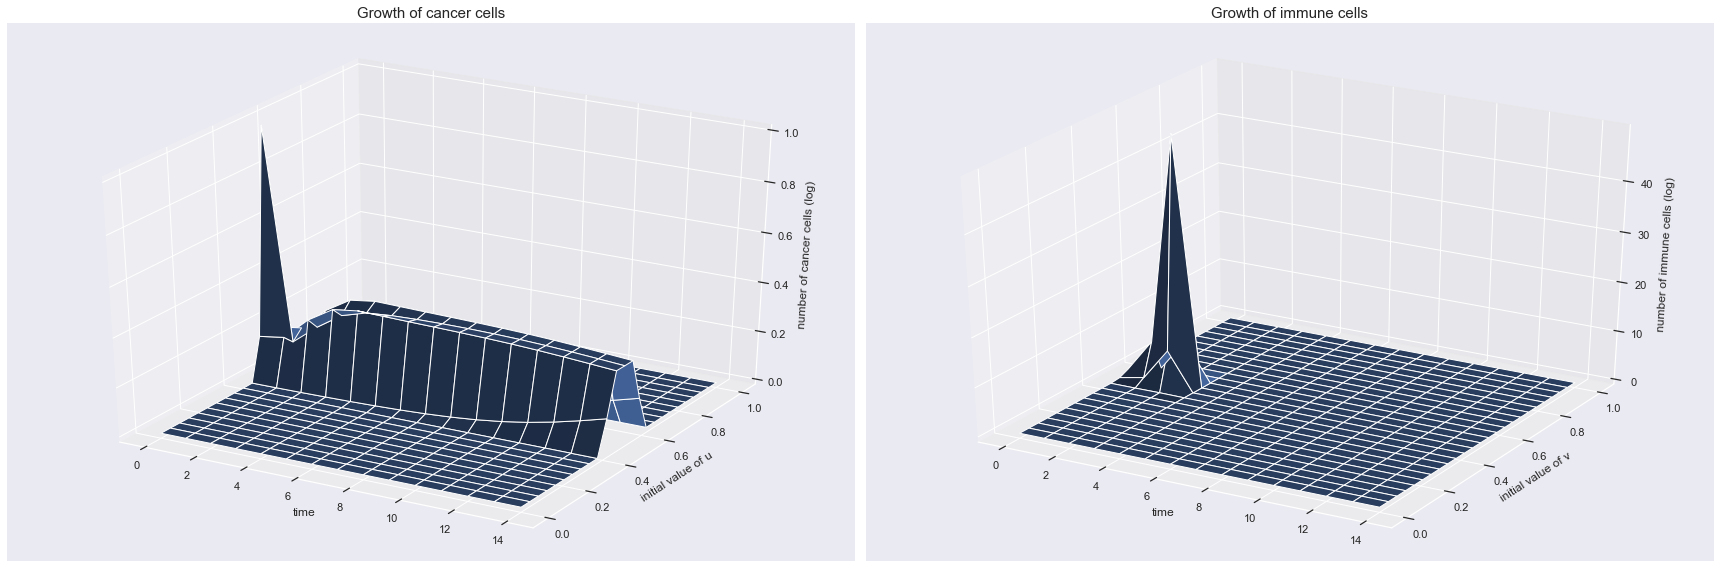

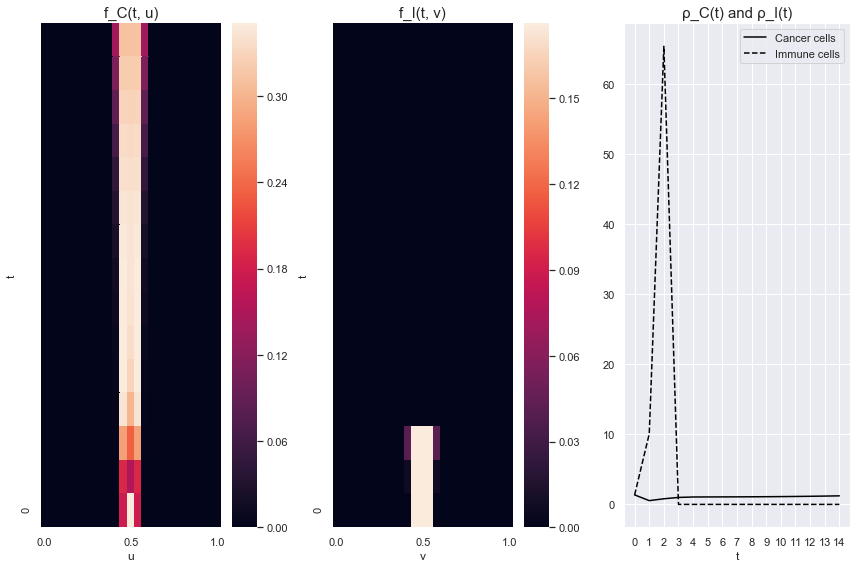

In [14]:
cancer, immune, initial_values = simulate_growth(c_P=lambda t: C*np.sign(np.sin(omega*t)), t=15)
plot_growth_surface(cancer, immune, initial_values, t=15)
plot_growth_cmap(cancer, immune, initial_values, t=15)

### Setting $c_P(t) = 0 \quad c_M(t) = C*\operatorname{sgn}(\sin(\omega*t))$

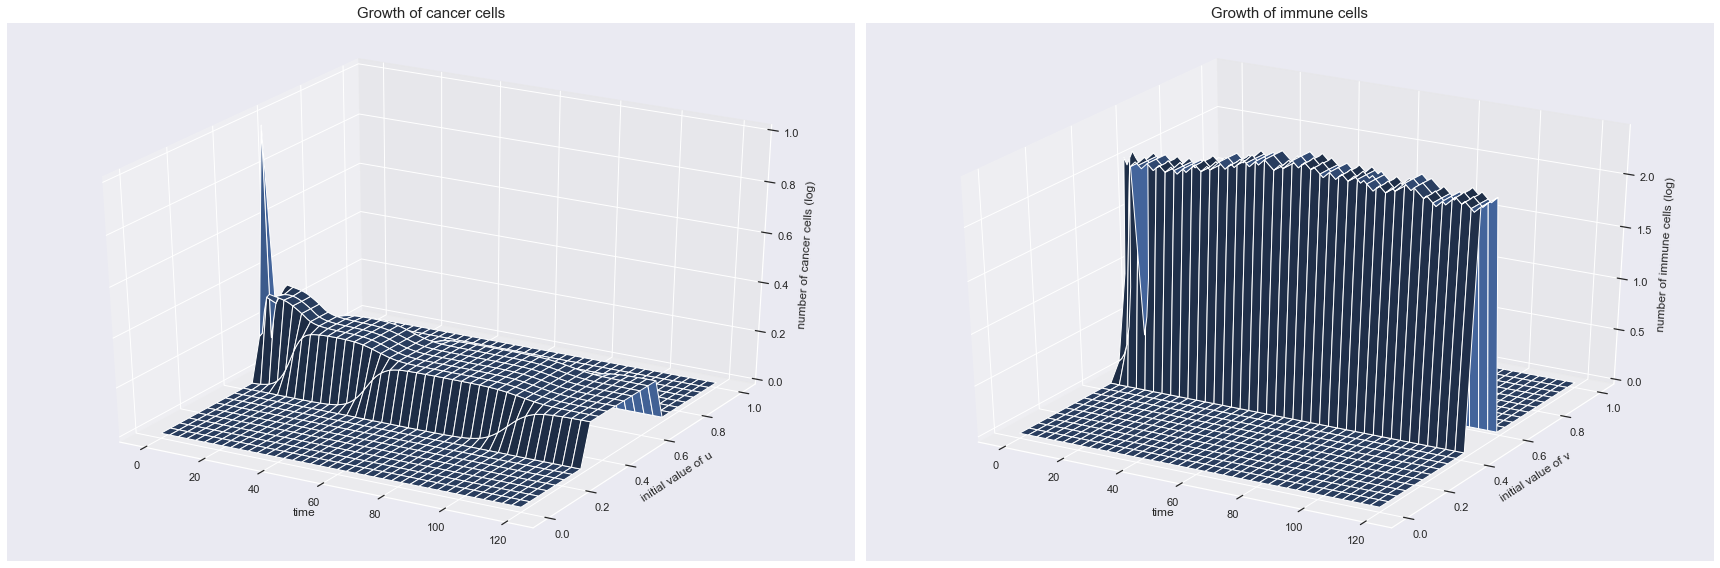

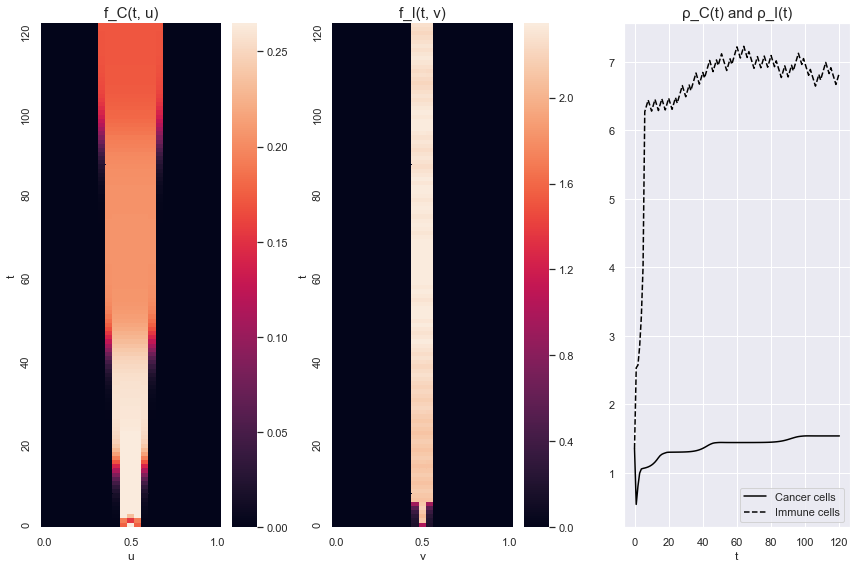

In [15]:
cancer, immune, initial_values = simulate_growth(c_M=lambda t: C*np.sign(np.sin(omega*t)))
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)

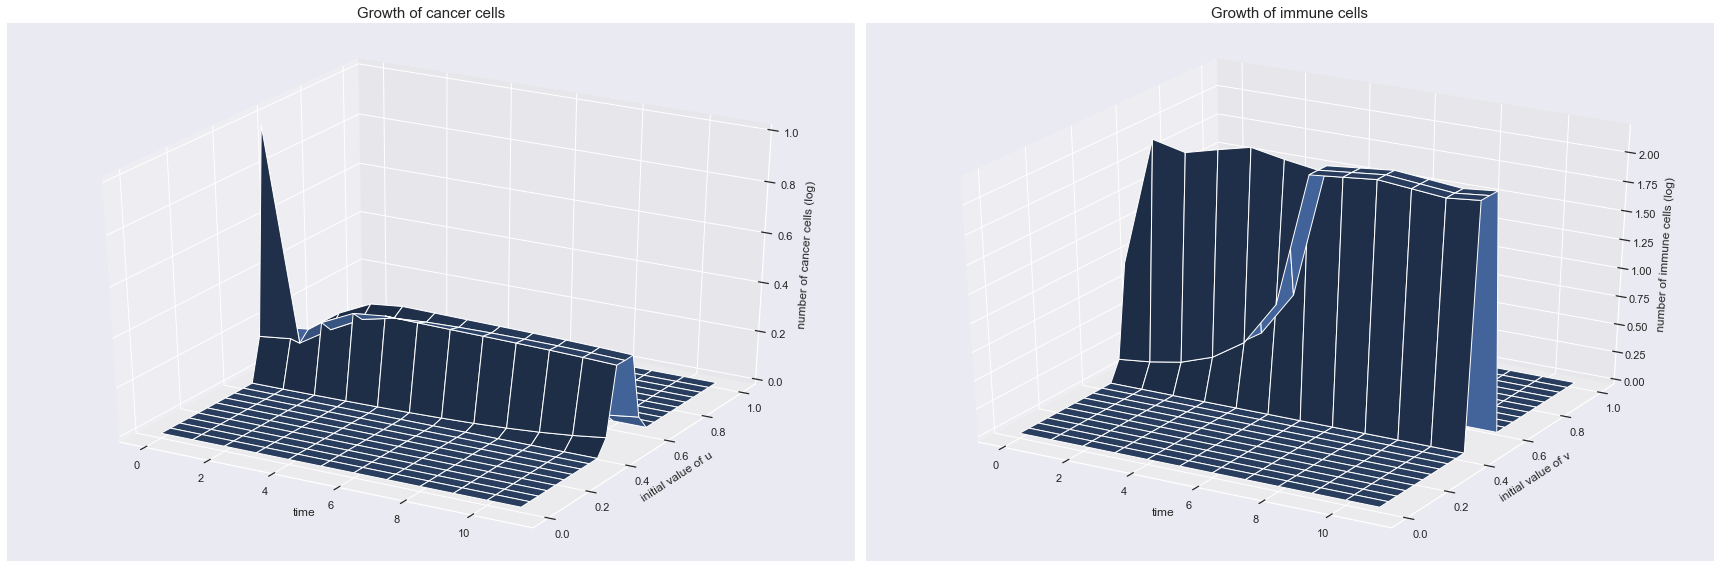

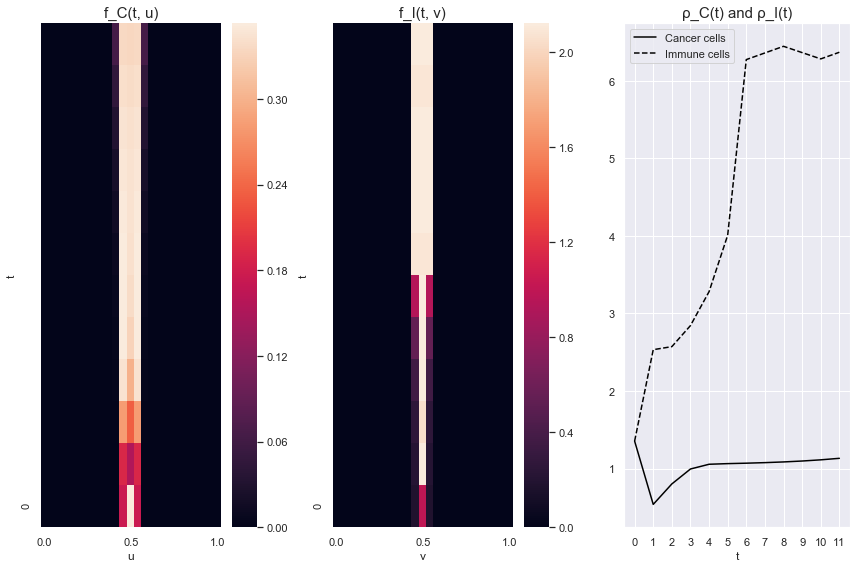

In [16]:
cancer, immune, initial_values = simulate_growth(c_M=lambda t: C*np.sign(np.sin(omega*t)), t=12)
plot_growth_surface(cancer, immune, initial_values, t=12)
plot_growth_cmap(cancer, immune, initial_values, t=12)

### Setting both $c_P(t) = \frac{C}{2}*\operatorname{sgn}(\sin(\omega*t)) \quad c_M(t) = \frac{C}{2}*\operatorname{sgn}(\sin(\omega*t))$

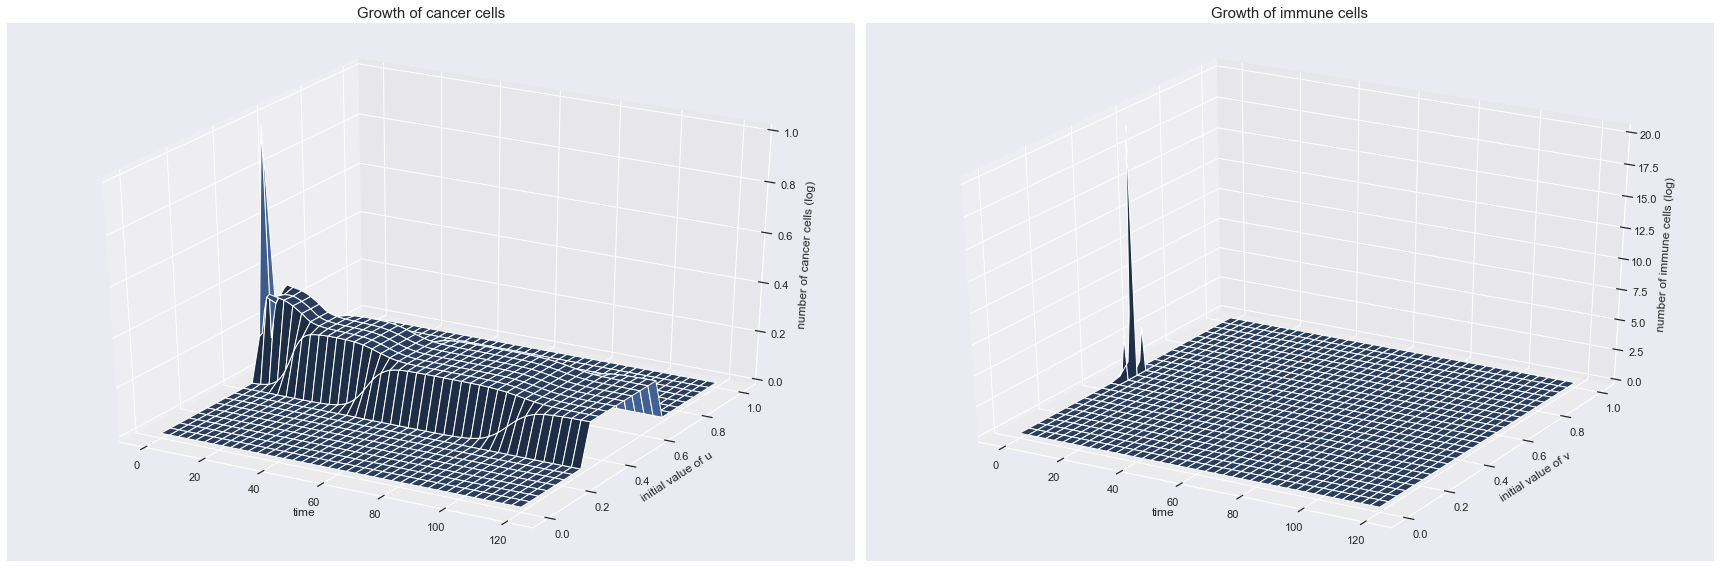

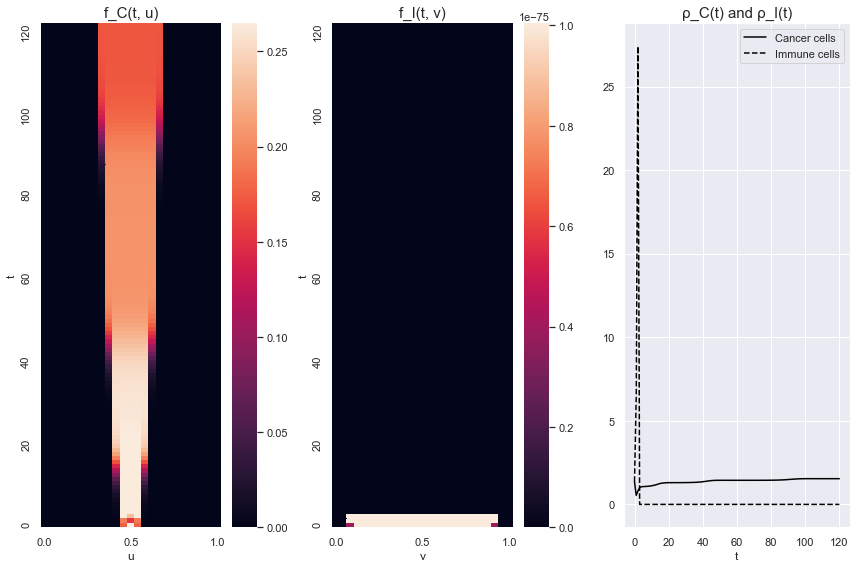

In [17]:
cancer, immune, initial_values = simulate_growth(c_P=lambda t: C/2*np.sign(np.sin(omega*t)),
                                                 c_M=lambda t: C/2*np.sign(np.sin(omega*t)))
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)

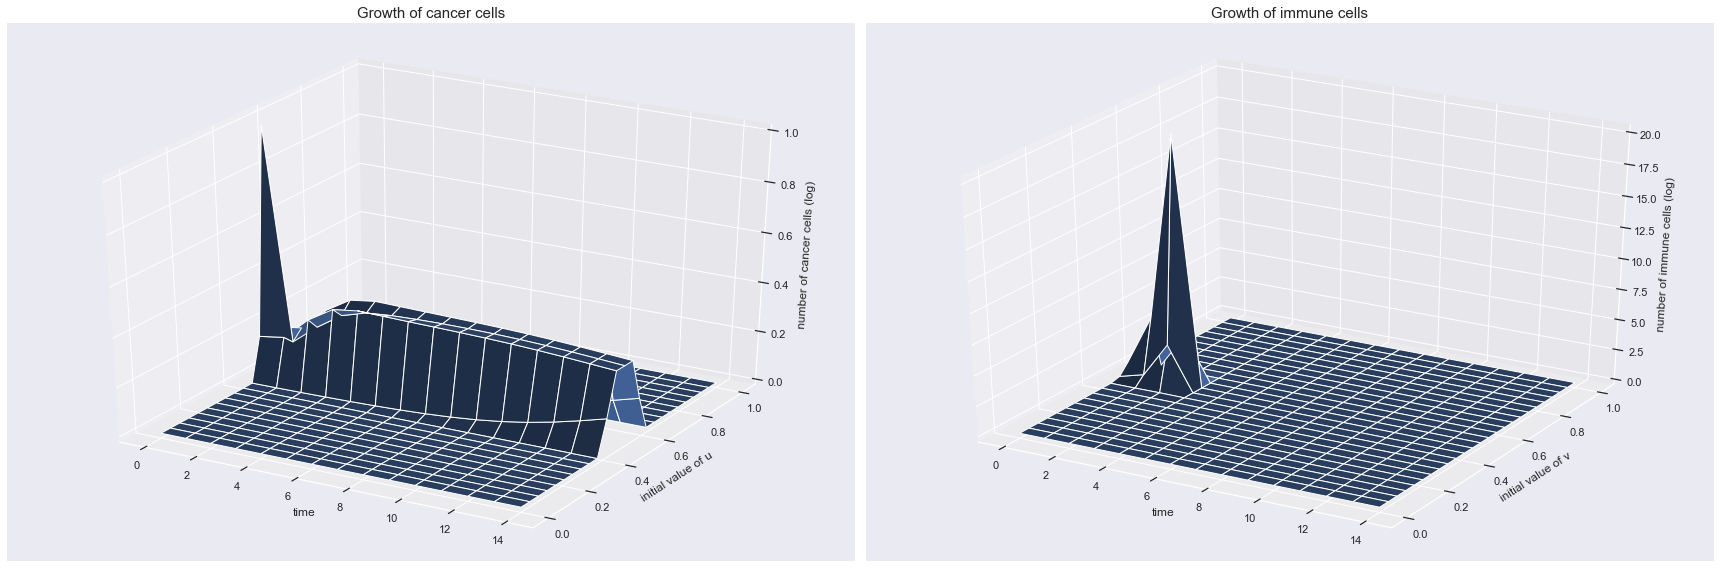

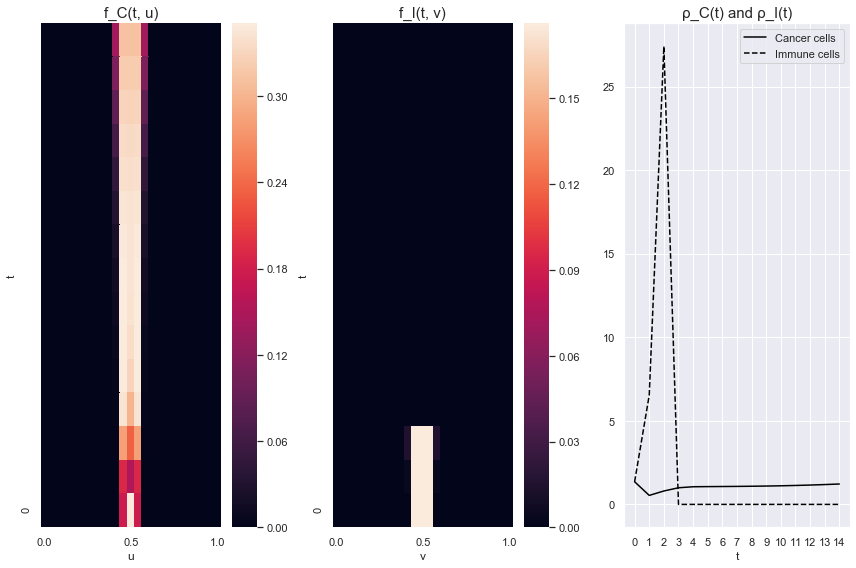

In [18]:
cancer, immune, initial_values = simulate_growth(c_P=lambda t: C/2*np.sign(np.sin(omega*t)),
                                                 c_M=lambda t: C/2*np.sign(np.sin(omega*t)), t=15)
plot_growth_surface(cancer, immune, initial_values, t=15)
plot_growth_cmap(cancer, immune, initial_values, t=15)